<a href="https://colab.research.google.com/github/gbuzzard/PnP-MACE/blob/dev-misc/demo/pnp_mace_ct_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Overview:** 

This demo illustrates the use of the `pnp_mace` package (source code available at https://github.com/gbuzzard/PnP-MACE, and documentation is at https://pnp-mace.readthedocs.io/) on a 2D tomography example using a high-dynamic range phantom that simulates characteristics found in scanned luggage.

More information about Plug-and-Play and MACE is available at links included in the documentation.  

This demo illustrates 2D tomography using a
high-dynamic range phantom.  First the radon transform is applied
using relatively sparse views.  Then proportional noise is added
and filtered backprojection applied to produce an initial
reconstruction.

The forward model is the forward radon transform, the
backprojection can be chosen as either filtered or unfiltered
backprojection, and the prior agent can be bm3d, a version of
TV, wavelet-based denoising, or bilateral.

Portions of this file are based on
https://github.com/gbuzzard/CT-Tutorial/blob/master/CT_Tutorial.ipynb


--

Copyright (C) 2021 by Greg Buzzard <buzzard@purdue.edu>
All rights reserved.

Permission is hereby granted, free of charge, to any person obtaining a copy of this 
software and associated documentation files (the "Software"), to deal in the Software 
without restriction, including without limitation the rights to use, copy, modify, merge, 
publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons 
to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or 
substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING 
BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. 
IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, 
WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE 
SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


In [31]:

!pip install scikit-image>=0.18.1
!pip install pnp_mace

import imageio
import numpy as np
import matplotlib.pyplot as plt

from skimage.transform import radon, resize, iradon
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral, denoise_wavelet)
import pnp_mace as pnpm
from dotmap import DotMap


**Set Basic Parameters**

In [32]:
# Set basic parameters
img_path = "https://www.math.purdue.edu/~buzzard/software/image01.png"
num_views = 60
mu0 = 0.6  # Forward agent weight
num_iters = 30

# Set the filter for filtered back projection.
filters = ['ramp', 'shepp-logan', 'cosine', 'hamming', 'hann', None]
filter_index = 0
filter_name = filters[filter_index]

# Set the denoiser for the prior agent
def denoiser(x, params):
    denoised_x = denoise_tv_chambolle(x, weight=params.noise_std)
    # denoised_x = denoise_bilateral(np.clip(x, a_min=0, a_max=None), sigma_spatial=1.5)
    # denoised_x = denoise_wavelet(x, sigma=0.2)
    return denoised_x


**High dynamic range images**

The images in this examples are designed to mimic single-energy (~100 KeV) CT images with high dynamic range. 

The pixel values are in Hounsfield units, with air as 0 and water as 1000. Hounsfield units are closely related to the atomic weight of the associated material. 

We then scale so that water is 1 and air is 0.
In these scaled units, steel and other dense metals are about 12 to 15, but may go up to 20.

The demo image has high dynamic range with some characteristics like those seen in CT scans of baggage.

With parallel beam CT, only the center circular region can be properly reconstructed. Here we mask to that region.

Note that if the image is resized here, then the pixel pitch (physical distance between pixels as measured on the object being imaged) must be adjusted later as part of scaling.



In [33]:
#
# Get the image, sinogram and baseline reconstruction
#
theta = np.linspace(0., 180., num_views, endpoint=False)
print("Reading data")

image_path = img_path
imsize=None


# The image is in Hounsfield units
# Convert to Hounsfield units/1000
orig_img = imageio.imread(image_path).astype(float)
ground_truth = orig_img / 1000.

# Set up the image mask to restrict to a circular ROI
cur_size = min(ground_truth.shape)
image_scale = 1

if imsize is not None and imsize != cur_size:
    image_scale = cur_size / imsize
    new_size = ground_truth.shape * image_scale
    ground_truth = resize(ground_truth, new_size.astype(int))

radius = min(ground_truth.shape) // 2

c0, c1 = np.ogrid[0:ground_truth.shape[0], 0:ground_truth.shape[1]]
mask = ((c0 - ground_truth.shape[0] // 2) ** 2
        + (c1 - ground_truth.shape[1] // 2) ** 2)
mask = (mask <= radius ** 2)
ground_truth = ground_truth * mask


Reading data


**Physically realistic scaling**

All CT scans are relative to a baseline scan with
no objects - i.e., a scan of air, which makes air 0.

The raw projection operator (radon function in python or matlab)
sums along pixels, with assumed distance 1 between pixels.  To get
the correct units, we need to scale.  The first step is raw
projection: $\text{Raw projection} = Ax$, 
where $x$ is the image as scaled above and $Ax$ is the output of the radon transform. 

This result needs to be scaled according to physical units.

We scale by the pixel pitch (distance between pixels) times the
x-ray density of water.

We assume pixel pitch of 0.93 mm = 0.093 cm and water density at
100KeV of 0.17 $\text{cm}^{-1}$.  With an image size of
512x512 pixels, this corresponds to a width of 512*0.93/10 = 47.16
cm or 18.75 in.  Scaling of the projection is then

$$y \text{ (or scaled projection) } = Ax * \text{pixel_pitch} *
    \text{water_xray_density}$$

Note that if the original image was resized, then we have to
adjust the pixel pitch accordingly so that the image has the same
physical dimensions.  For example, if the image was resized from
512x512 to 256x256, then the pixel pitch is increased by a factor
of two.

The sinogram values should be on the order of 0-5 for most images.
Here are approximate X-ray densities for common materials you
might have in an image

* water ~0.17 $\text{cm}^{-1}$
* steel ~3.0 $\text{cm}^{-1}$
* aluminum ~1.0 $\text{cm}^{-1}$
* plastic ~0.1 $\text{cm}^{-1}$


In [34]:
#
# Get the scaled sinogram
#
print("Creating sinogram")

# Set the sinogram scaling factor
pixel_pitch = 0.093  # in cm
water_xray_density = 0.17  # in cm^{-1}

pixel_pitch = pixel_pitch / image_scale
sino_scale = pixel_pitch * water_xray_density

# Forward projection to get the sinogram, scaled as above.
sinogram = radon(ground_truth, theta=theta, circle=True)
sinogram *= sino_scale



Creating sinogram


/usr/local/lib/python3.7/dist-packages/skimage/transform/radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])


**Realistic noise modeling**

The noise is modeled as additive noise but with
variance that depends on the signal.

$$ y_{noise} = y + w$$

For an entry $y(i)$, the noise $w(i)$ is
$N(0, \sigma^2(i))$ with

$$    \sigma^2(i) = \frac{1}{\lambda_0} \exp(y(i)),$$

where $\lambda_0$ is the photon count at the detector for an
empty scan. For convenience, we define $\alpha = 1/\lambda_0$.



In [35]:

# Sinogram noise variance scaling
lambda0 = 16000  # photon count for blank scan
alpha = 1 / lambda0

# Add noise to the sinogram
w = np.sqrt(alpha * np.exp(sinogram)) * np.random.standard_normal(
    sinogram.shape)
noisy_sinogram = sinogram + w  # This will be used as the noisy data to fit


**Baseline reconstruction**

Use filtered backprojection for baseline recon.

Invert the radon transform using filtered backprojection for both
the noise-free and noisy sinograms.

Since the sinogram was scaled using sino_scale as described above,
we need to apply the inverse scaling to the reconstructions.


In [36]:
#
# Get the baseline reconstruction with FBP
#
print("Creating FBP reconstruction")
# Invert the radon transform in the noise-free and noisy cases
fbp_recon = iradon(sinogram, theta=theta, circle=True)
fbp_noisy_recon = iradon(noisy_sinogram, theta=theta, circle=True)

# Scale to recover the appropriate units
fbp_recon = fbp_recon / sino_scale
fbp_noisy_recon = fbp_noisy_recon / sino_scale



Creating FBP reconstruction


**Equilibrium problem and forward agent**

The MACE formulation uses a collection of agents and seeks an equilibrium among their actions.  He we set up the forward agents, which seek to fit the data.  

In this case, the forward agent is defined by taking the curent reconstruction, projecting it to a sinogram, taking the difference with data, and using backprojection into the image domain.  Scaling the result produces an update, which is added to the current starting point during each iteration. 

When the backprojection is the transpose of the forward projection, this formulation agrees with a standard Bayesian inverse problem.  However, other backprojections are allowed (e.g., various kinds of filtered backprojection).  This is known as mismatched backprojection and can enhance results in some circumstances. 

In [37]:
#
# Set up the forward agent.
# We'll use a linear prox map, so we need to define A (radon transform)
# and AT (back projection).
#
def A(x):
    return sino_scale * radon(x, theta=theta, circle=True)

def AT(x):
    return iradon(x, theta=theta, circle=True) / sino_scale

step_size = 0.1
forward_agent = pnpm.LinearProxForwardAgent(noisy_sinogram, A, AT,
                                            step_size)



**Prior agent**

The prior agent is typically a denoiser.  In this case, the choice of denoiser is specified above under the selection of basic parameters.  

In [38]:
#
# Set up the prior agent - a denoiser together with the mask to
# ensure a proper ROI.
#
def prior_agent_method(x, params):
    denoised_x = denoiser(x, params)
    return mask * denoised_x

prior_params = DotMap()
prior_params.noise_std = step_size

prior_agent = pnpm.PriorAgent(prior_agent_method, prior_params)


**Image display utility**

Note that these images have a scale bar to indicate the intensity
and that all the images are scaled to have the same intensity
range.  We show several intensity bands to highlight the high
dynamic range.  The reconstructions have values outside the given
range, so the intensities are clipped, but the full range is shown
in the titles.


In [39]:
def display_images(image_list, image_titles, ground_truth):
    r"""
    Display images to capture high dynamic range.

    Args:
        image_list: list of images to display
        image_titles: title for the images
        ground_truth: ground truth image for calculating NRMSE

    Returns:
        None
    """

    titles = []
    for img, title in zip(image_list, image_titles):
        cur_min = np.round(np.amin(img), 1)
        cur_max = np.round(np.amax(img), 1)
        bounds = '{} to {}'.format(str(cur_min), str(cur_max))
        nrmse = pnpm.nrmse(img, ground_truth)
        titles.append(title + ' [NRMSE: ' + str(nrmse) +
                      ']\n (full range is ' + bounds + ' )')

    vmin = [0, 2, 8]
    vmax = [2, 8, 15]

    num_scales = len(vmin)

    for img, title in zip(image_list, titles):

        fig, ax = plt.subplots(nrows=1, ncols=num_scales,
                               figsize=(4.5*num_scales, 5))

        for k in range(num_scales):
            # display at various scales
            range_title = "Range: " + str(vmin[k]) + " to " + str(vmax[k])
            pnpm.display_image(img, title=range_title, fig=fig, ax=ax[k],
                               vmin=vmin[k], vmax=vmax[k], cmap="viridis")
            #plt.colorbar()

        plt.suptitle(title)
        plt.tight_layout()
        fig.show()



**Display the result of one forward step and one prior step**

/usr/local/lib/python3.7/dist-packages/skimage/transform/radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])


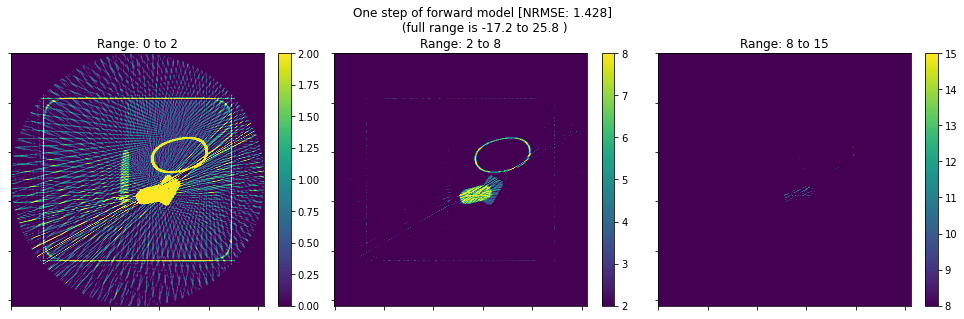

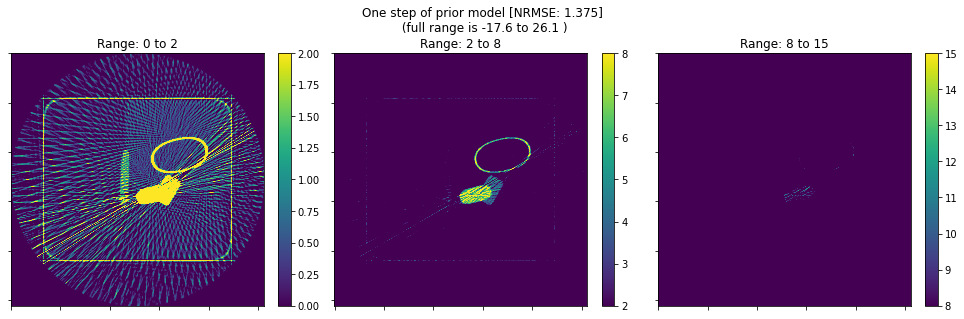

In [40]:
#
# Compute and display one step of forward and prior agents.
#
init_recon = fbp_noisy_recon
one_step_forward = forward_agent(np.asarray(init_recon))
one_step_prior = prior_agent(np.asarray(init_recon))

display_images([one_step_forward, one_step_prior], ['One step of forward model', 'One step of prior model'], ground_truth)


**Set parameters for equilibrium problem**

In [41]:
#
# Set up the equilibrium problem
#
mu = [mu0, 1 - mu0]
rho = 0.5
keep_all_images = False

equil_params = DotMap()
equil_params.mu = mu
equil_params.rho = rho
equil_params.num_iters = num_iters
equil_params.keep_all_images = keep_all_images
equil_params.verbose = True

agents = [forward_agent, prior_agent]
equil_prob = pnpm.EquilibriumProblem(agents, pnpm.mann_iteration_mace,
                                      equil_params)

init_images = pnpm.stack_init_image(init_recon, len(agents))



**Call the MACE solver**

In [42]:
#
# Compute MACE solution
#
final_images, residuals, vectors, all_images = equil_prob.solve(
    init_images)


Starting Mann iterations


/usr/local/lib/python3.7/dist-packages/skimage/transform/radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])


Finished iteration 1 of 30
Finished iteration 2 of 30
Finished iteration 3 of 30
Finished iteration 4 of 30
Finished iteration 5 of 30
Finished iteration 6 of 30
Finished iteration 7 of 30
Finished iteration 8 of 30
Finished iteration 9 of 30
Finished iteration 10 of 30
Finished iteration 11 of 30
Finished iteration 12 of 30
Finished iteration 13 of 30
Finished iteration 14 of 30
Finished iteration 15 of 30
Finished iteration 16 of 30
Finished iteration 17 of 30
Finished iteration 18 of 30
Finished iteration 19 of 30
Finished iteration 20 of 30
Finished iteration 21 of 30
Finished iteration 22 of 30
Finished iteration 23 of 30
Finished iteration 24 of 30
Finished iteration 25 of 30
Finished iteration 26 of 30
Finished iteration 27 of 30
Finished iteration 28 of 30
Finished iteration 29 of 30
Finished iteration 30 of 30


**Display the final results**

Note that the equilibrium solution is significantly better than the result of the one-step results shown above.   

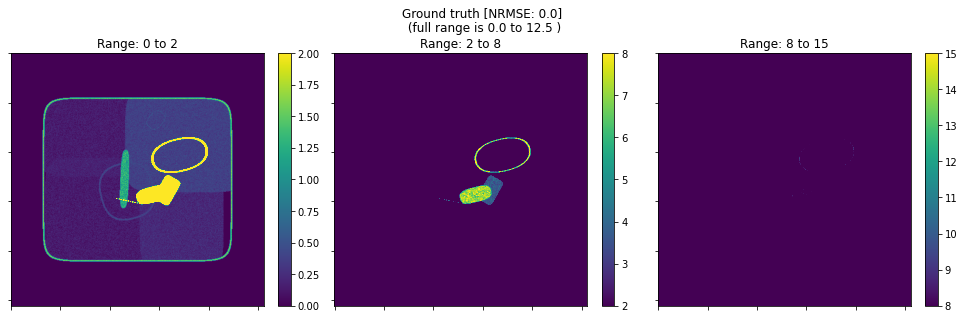

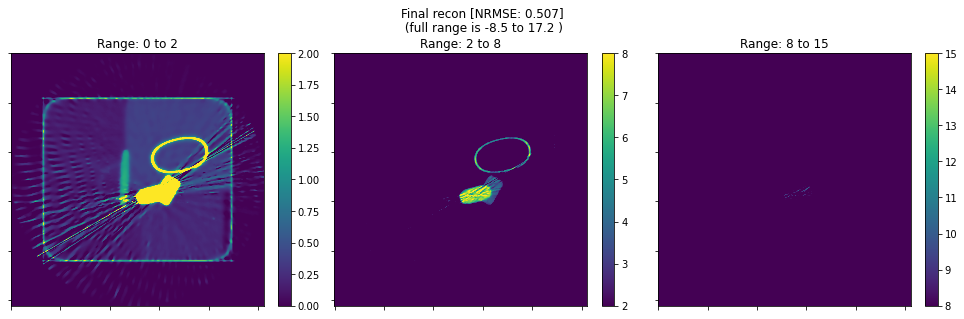

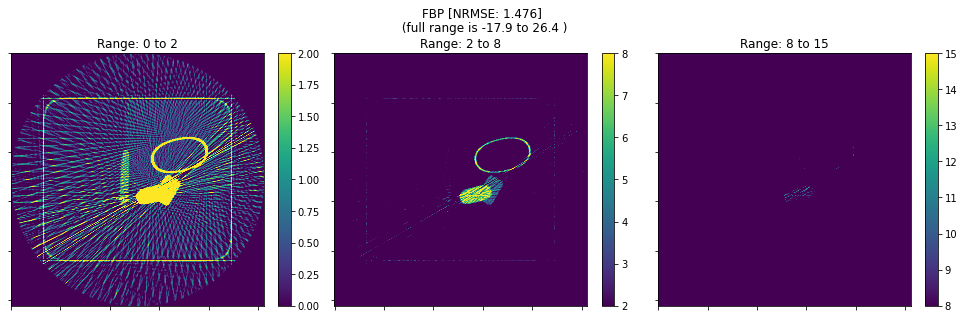

In [43]:
#
# Display results.
#
im = final_images[0]
display_images([ground_truth, im, fbp_noisy_recon], ['Ground truth', 'Final recon', 'FBP'], ground_truth)

